In [44]:
import os
import sys
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Project paths
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, "models"))

# Custom modules
from dataset import BrainTumorDataset
from create_multimodal_dataset import ResNetFeatureExtractor
from pytorch_tabnet.tab_model import TabNetClassifier

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [52]:
MODEL_PATH = "tabnet_brain_tumor_classifier.pth.zip"  # Make sure this is the correct file
tabnet = TabNetClassifier()
tabnet.load_model(MODEL_PATH)
print(f"TabNet model loaded successfully from {MODEL_PATH}")


c:\Users\KRISTINE\projects\brain-tumour-multimodal-analysis\venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


TabNet model loaded successfully from tabnet_brain_tumor_classifier.pth.zip


In [46]:
DATA_ROOT = "../data"
test_root_dir = os.path.join(DATA_ROOT, "Testing")

# Use same transforms as training
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = BrainTumorDataset(root_dir=test_root_dir, transform=image_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class_names = [test_dataset.idx_to_class[i] for i in sorted(test_dataset.idx_to_class.keys())]
print(f"Found {len(test_dataset)} test images across {len(class_names)} classes.")


Class to index mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Found 394 test images across 4 classes.


In [53]:
DATA_ROOT = "../data"
test_root_dir = os.path.join(DATA_ROOT, "Testing")

# Image transforms (same as during training)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Test dataset & loader
test_dataset = BrainTumorDataset(root_dir=test_root_dir, transform=image_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class_names = [test_dataset.idx_to_class[i] for i in sorted(test_dataset.idx_to_class.keys())]
print(f"Found {len(test_dataset)} test images across {len(class_names)} classes.")


Class to index mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Found 394 test images across 4 classes.


In [54]:
# Initialize feature extractor
RESNET_MODEL_PATH = "resnet_brain_tumor_classifier.pth"
feature_extractor = ResNetFeatureExtractor(model_path=RESNET_MODEL_PATH, device=device)

# Extract features for all test images
X_test, y_true, image_paths = feature_extractor.extract_features_from_loader(
    test_loader, desc="Extracting test features"
)

print(f"Feature extraction complete. X_test shape: {X_test.shape}, y_true shape: {len(y_true)}")


Using device: cpu
ResNet Feature Extractor initialized.


Extracting test features: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

Feature extraction complete. X_test shape: (394, 2048), y_true shape: 394


In [55]:
# TabNet predictions
y_pred = tabnet.predict(X_test)

# Convert to numpy array if needed
y_pred = np.array(y_pred)
y_true = np.array(y_true)


In [56]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
accuracy = accuracy_score(y_true, y_pred)

print("\n--- TabNet Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")



--- TabNet Classification Report ---
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.28      0.44       100
meningioma_tumor       0.80      0.93      0.86       115
        no_tumor       0.63      1.00      0.77       105
 pituitary_tumor       1.00      0.91      0.95        74

        accuracy                           0.78       394
       macro avg       0.86      0.78      0.76       394
    weighted avg       0.85      0.78      0.75       394


Overall Accuracy: 77.92%


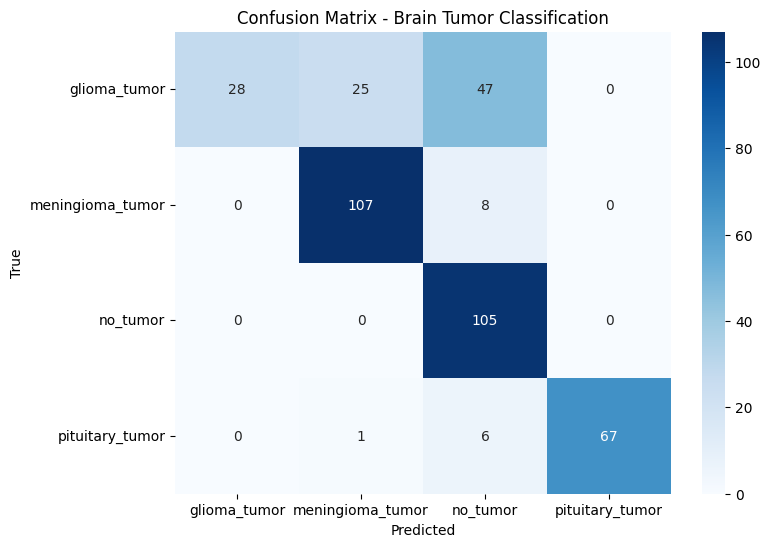

In [57]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Brain Tumor Classification')
plt.show()


Extracting sample features: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


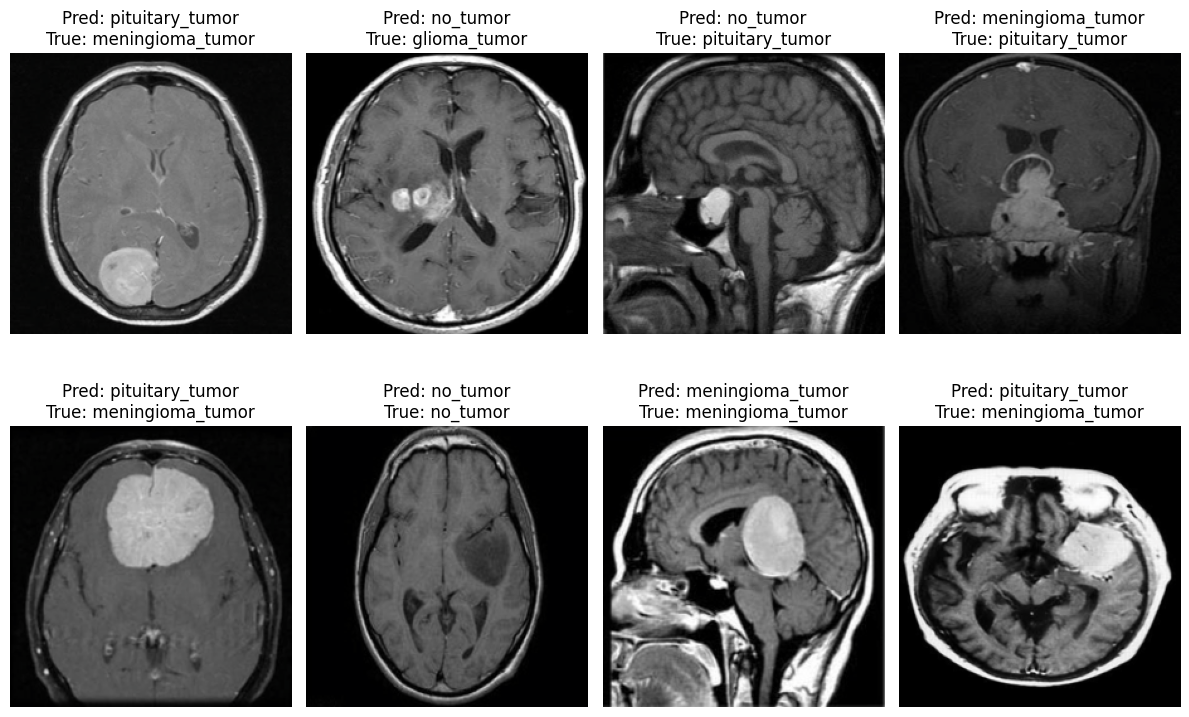

In [58]:
# Load a small batch of images to show predictions
sample_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
sample_batch = next(iter(sample_loader))
images, labels = sample_batch['image'], sample_batch['label']

# Extract features for sample images
sample_features, _, _ = feature_extractor.extract_features_from_loader(
    sample_loader, desc="Extracting sample features"
)
sample_preds = tabnet.predict(sample_features)

plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    img = images[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[sample_preds[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
